In [59]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import dotenv
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from isrobust.utils import set_all_seeds

project_path = Path(dotenv.find_dotenv()).parent
data_path = project_path.joinpath("data")

set_all_seeds(seed=42)

tf.config.experimental.enable_op_determinism()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
config = dotenv.dotenv_values()

stop = float(config["FRAC_STOP"])
start = float(config["FRAC_START"])
step = float(config["FRAC_STEP"])
n_steps = int(np.ceil((stop - start) / step) + 1)

frac_list = np.linspace(start, stop, n_steps, endpoint=True)
frac_list

array([0.05, 0.1 , 0.15])

In [65]:
results_path = Path(config["RESULTS_FOLDER"]).resolve()
figs_path = results_path.joinpath("figs")
tables_path = results_path.joinpath("tables")

In [66]:
results_path

PosixPath('/home/cloucera/github/robustness_informed/results/robustness_informed')

In [67]:
models = ["ivae_kegg", "ivae_reactome"] + [
    f"ivae_random-{frac:.2f}" for frac in frac_list
]
models

['ivae_kegg',
 'ivae_reactome',
 'ivae_random-0.05',
 'ivae_random-0.10',
 'ivae_random-0.15']

In [68]:
# Metrics

metric_scores = [
    pd.read_pickle(results_path.joinpath(m, "scores_metrics.pkl")) for m in models
]
metric_scores = pd.concat(metric_scores, axis=0, ignore_index=True)
metric_scores = metric_scores
metric_scores.head()

,seed,metric,split,score,model
0,0,loss,train,2.942321,ivae_kegg
1,0,mse,train,0.000786,ivae_kegg
2,0,loss,val,2.933811,ivae_kegg
3,0,mse,val,0.000790,ivae_kegg
4,0,loss,test,2.953722,ivae_kegg


In [69]:
# clustering

clustering_scores = [
    pd.read_pickle(results_path.joinpath(m, "scores_clustering.pkl")) for m in models
]
clustering_scores = pd.concat(clustering_scores, axis=0, ignore_index=True)
clustering_scores.head()

,split,layer,score,model
0,train,1,0.449563,ivae_kegg
1,train,1,0.422944,ivae_kegg
2,train,1,0.392982,ivae_kegg
3,train,1,0.355757,ivae_kegg
4,train,1,0.451032,ivae_kegg


In [70]:
clustering_scores.groupby(["model", "layer"]).size()

model             layer
ivae_kegg         1        33
                  2        33
ivae_random-0.05  1        33
ivae_random-0.10  1        33
ivae_random-0.15  1        33
ivae_reactome     1        33
dtype: int64

In [71]:
# informed

informed_scores = [
    pd.read_pickle(results_path.joinpath(m, "scores_informed.pkl")) for m in models
]
informed_scores = pd.concat(informed_scores, axis=0, ignore_index=True)
informed_scores.head()

,split,layer,score,model
0,train,1,0.787101,ivae_kegg
1,train,1,0.728475,ivae_kegg
2,train,1,0.783498,ivae_kegg
3,train,1,0.769732,ivae_kegg
4,train,1,0.797193,ivae_kegg


In [72]:
informed_scores.head()

,split,layer,score,model
0,train,1,0.787101,ivae_kegg
1,train,1,0.728475,ivae_kegg
2,train,1,0.783498,ivae_kegg
3,train,1,0.769732,ivae_kegg
4,train,1,0.797193,ivae_kegg


In [73]:
clustering_scores["kind"] = "clustering"
informed_scores["kind"] = "informed"

In [74]:
metric_scores_filt = metric_scores.rename(columns={"metric": "kind"}).query(
    "split=='test' & kind=='mse'"
)[["score", "model", "kind"]]

In [75]:
scores = (
    pd.concat((clustering_scores, informed_scores), axis=0, ignore_index=True)
    .query("layer==1 & split=='test'")
    .drop(["layer", "split"], axis=1)
)
scores = pd.concat((scores, metric_scores_filt), axis=0, ignore_index=True)
scores.head()

,score,model,kind
0,0.445743,ivae_kegg,clustering
1,0.427972,ivae_kegg,clustering
2,0.381412,ivae_kegg,clustering
3,0.349151,ivae_kegg,clustering
4,0.427790,ivae_kegg,clustering


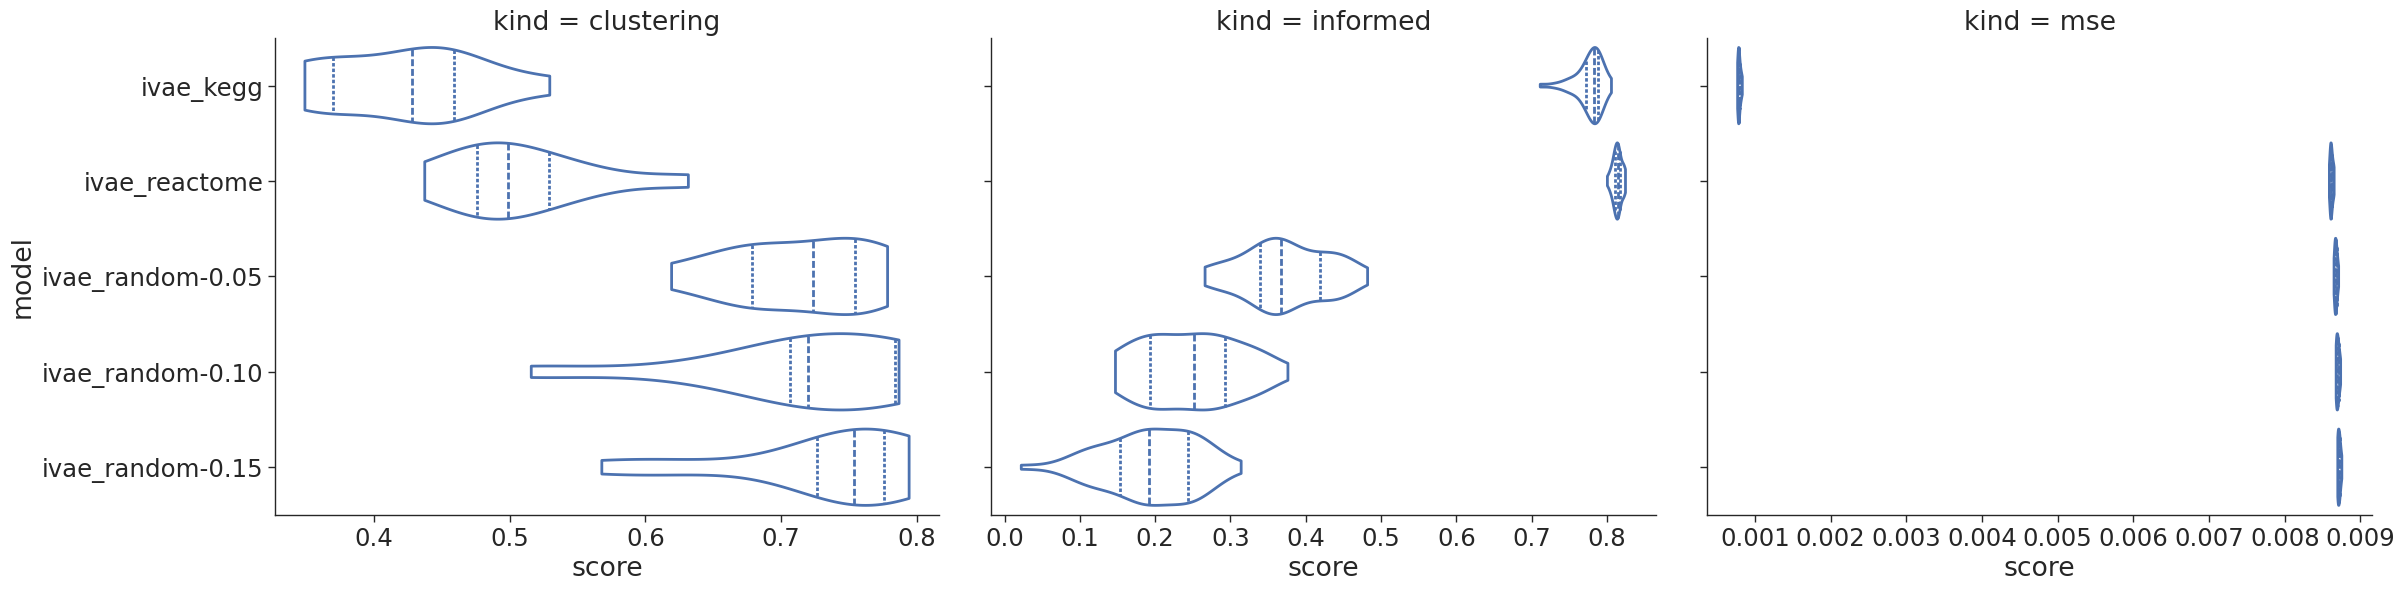

In [76]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context="paper", font_scale=2, style="ticks", rc=custom_params)
fac = 0.7

g = sns.catplot(
    data=scores,
    kind="violin",
    col="kind",
    height=9 * fac,
    aspect=16 / 9 * fac,
    sharey=True,
    sharex=False,
    y="model",
    x="score",
    split=False,
    cut=0,
    fill=False,
    density_norm="count",
    inner="quart",
    linewidth=2,
    legend_out=False,
    col_wrap=4,
)

In [77]:
informed_scores.groupby(["model", "kind", "split", "layer"]).describe()

score                                \
                                      count      mean       std       min   
model            kind     split layer                                       
ivae_kegg        informed test  1      55.0  0.777200  0.018028  0.711560   
                                2      55.0  0.303116  0.098885  0.073059   
                          train 1      55.0  0.777112  0.018034  0.710903   
                                2      55.0  0.303331  0.098263  0.074184   
                          val   1      55.0  0.774924  0.018036  0.710924   
                                2      55.0  0.303081  0.098438  0.069676   
ivae_random-0.05 informed test  1      55.0  0.373402  0.054625  0.266259   
                          train 1      55.0  0.372859  0.054971  0.256982   
                          val   1      55.0  0.374216  0.055309  0.256073   
ivae_random-0.10 informed test  1      55.0  0.246380  0.062250  0.147205   
                          train 1      55.0  0.246534  0.061960  0.138195   
                          val   1      55.0  0.247495  0.062591  0.138573   
ivae_random-0.15 informed test  1      55.0  0.194422  0.060327  0.022062   
                          train 1      55.0  0.193937  0.059611  0.025901   
                          val   1      55.0  0.195338  0.060470  0.028513   
ivae_reactome    informed test  1      55.0  0.814151  0.005807  0.800804   
                          train 1      55.0  0.814228  0.005754  0.800636   
                          val   1      55.0  0.813707  0.005851  0.799961   

                                                                               
                                            25%       50%       75%       max  
model            kind     split layer                                          
ivae_kegg        informed test  1      0.771807  0.783066  0.788360  0.806189  
                                2      0.229568  0.309386  0.371017  0.495354  
                          train 1      0.770760  0.782558  0.788643  0.806171  
                                2      0.230902  0.309529  0.368749  0.487892  
                          val   1      0.768221  0.778643  0.786880  0.804092  
                                2      0.230556  0.310342  0.369048  0.489393  
ivae_random-0.05 informed test  1      0.339228  0.367043  0.419309  0.482197  
                          train 1      0.341834  0.366840  0.417385  0.479246  
                          val   1      0.340740  0.370032  0.419442  0.477895  
ivae_random-0.10 informed test  1      0.192803  0.250894  0.292741  0.376341  
                          train 1      0.192899  0.247734  0.293208  0.375808  
                          val   1      0.197687  0.244853  0.292336  0.373137  
ivae_random-0.15 informed test  1      0.153526  0.192245  0.243689  0.314218  
                          train 1      0.156354  0.192140  0.239254  0.314007  
                          val   1      0.154713  0.197942  0.242341  0.310484  
ivae_reactome    informed test  1      0.810333  0.814256  0.817240  0.824823  
                          train 1      0.810722  0.814070  0.817204  0.824835  
                          val   1      0.810099  0.813583  0.817010  0.824477